<a href="https://colab.research.google.com/github/GhadiElHasbani/NMA_project-FacesHouses/blob/daniel/Copie_de_load_ECoG_faceshouses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Miller ECoG data of faces/houses (+ noise)

includes some visualizations

In [1]:
# @title Data retrieval
import os, requests

fname = 'faceshouses.npz'
url = "https://osf.io/argh7/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
# @title Install packages (`nilearn`, `nimare`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
#!pip install nilearn --quiet
#!pip install nimare --quiet
#!pip install mne --quiet
#!pip install vtk --quiet
#!pip install pyvista --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt
#rcParams['figure.figsize'] = [20, 4]
#rcParams['font.size'] = 15
#rcParams['axes.spines.top'] = False
#rcParams['axes.spines.right'] = False
#rcParams['figure.autolayout'] = True

In [3]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here.
dat1 = alldat[1][0]
dat2 = alldat[1][1]

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['stim_id', 'stim_cat', 'stim_noise', 't_on', 't_off', 'key_press', 'V', 'categories', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. We plan to curate a few more before NMA starts. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

`alldat` contains 7 subjects each with two sessions `dat1` and `dat2`, and was originally used in these publications: 

*Miller, Kai J., et al. "Face percept formation in human ventral temporal cortex." Journal of neurophysiology 118.5 (2017): 2614-2627.*

*Miller, Kai J., et al. "The physiology of perception in human temporal lobe is specialized for contextual novelty." Journal of neurophysiology 114.1 (2015): 256-263.*

*Miller, Kai J., et al. "Spontaneous decoding of the timing and content of human object perception from cortical surface recordings reveals complementary information in the event-related potential and broadband spectral change." PLoS computational biology 12.1 (2016): e1004660.*

*Miller, Kai J., et al. "The physiology of perception in human temporal lobe is specialized for contextual novelty." Journal of neurophysiology 114.1 (2015): 256-263.*

*Miller, Kai J., et al. "Spontaneous decoding of the timing and content of human object perception from cortical surface recordings reveals complementary information in the event-related potential and broadband spectral change." PLoS computational biology 12.1 (2016): e1004660.*

In this task, subjects in a clinical settings (with ECoG implants) are passively shown faces and house during the first experiment (`dat1`). Then in the second experiment in the same subjects (`dat2`), noise is added to face and houses images and the subject has to detect the faces by pressing a key. Two of the subjects don't have keypresses. 

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size. 

Experiment 1: 
* `dat1['V']`: continuous voltage data (time by channels)
* `dat1['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat1['t_on']`: time of stimulus onset in data samples
* `dat1['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat1['stim_id`]: identity of stimulus from 1-100, with 1-50 being houses and 51-100 being faces
* `dat1['locs`]: 3D electrode positions on the brain surface

Experiment 2: 
* `dat2['V`]: continuous voltage data (time by channels)
* `dat2['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat2['t_on']`: time of stimulus onset in data samples
* `dat2['t_off']`: time of stimulus offset, always 1000 samples after `t_on`, with no inter-stimulus interval
* `dat2['stim_id`]: identity of stimulus from 1-600 (not really useful, since we don't know which ones are the same house/face)
* `dat2['stim_cat']`: stimulus category (1 = house, 2 = face)
* `dat2['stim_noise']`: percent noise from 0 to 100
* `dat2['key_press']`: when the subject thought the image was a face
* `dat2['categories']`: categories legend (1 = house, 2 = face)
* `dat2['locs`]: 3D electrode positions on the brain surface


# Code #

In [4]:
from sklearnex import patch_sklearn

patch_sklearn()

from sklearn import pipeline
from sklearn import svm
from sklearn import linear_model
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics
from sklearn import discriminant_analysis
import mne
import numpy as np
mne.set_log_level("INFO")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
subjects = []

with mne.use_log_level("WARNING"):
    # For each subject, iterate over datasets (clean and noisy)
    for i, subject in enumerate(alldat):
        srate = np.squeeze(subject[0]["srate"])
        dataset_epochs = []
        for dataset in subject:

            # Get MNI locations
            locs = dataset["locs"]

            # Create events and labels from onset timings
            stim_onset = dataset["t_on"]
            if "stim_cat" in dataset:
                stim_category = np.squeeze(dataset["stim_cat"]).astype(int) + 10
                event_id = {str(v) + "/noisy": int(k)+10 for k, v in dataset["categories"].items()}
            else:
                stim_category = (dataset["stim_id"] > 50) + 1
                event_id = {"house/clean": 1, "face/clean": 2}
                
            events = np.swapaxes(np.vstack([stim_onset, np.zeros_like(stim_onset), stim_category]), 0, 1)

            # Create annotations for relevant events
            stim_offset = dataset["t_off"]
            annotation_start = np.squeeze(stim_onset) / srate
            annotation_duration = np.squeeze(stim_offset - stim_onset) / srate
            annotation_description = np.squeeze(stim_category)
            if False and "key_press" in dataset:
                key_onset = dataset["key_press"]
                annotation_start = np.hstack((annotation_start, key_onset / 1000))
                annotation_duration = np.hstack((annotation_duration, np.zeros_like(key_onset)))
                annotation_description = np.hstack((annotation_description, np.full_like(key_onset, "keypress", dtype=str)))

            annotations = mne.Annotations(annotation_start, annotation_duration, annotation_description)

            # Create info file about the dataset, including locations 
            info = mne.create_info(ch_names=locs.shape[0], sfreq=srate, ch_types="ecog")
            montage = mne.channels.make_dig_montage(ch_pos={str(i): locs[i,...] / 1000 for i in range(locs.shape[0])}, coord_frame="mri")
            
            # Load raw data and apply information and locations data
            raw_data = mne.io.RawArray(np.swapaxes(dataset["V"], 0, 1), info=info)
            raw_data.set_montage(montage)
            raw_data.set_annotations(annotations)

            # Epoch the data
            print(event_id)
            dataset_epochs.append(mne.Epochs(raw_data, events, event_id, tmin=-0.2, tmax=0.8, baseline=None, preload=True))
        epoch_data = mne.concatenate_epochs(dataset_epochs, add_offset=100000, on_mismatch="raise", verbose=True)
        subjects.append(epoch_data)

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_data.set_montage(montage)


{'house/clean': 1, 'face/clean': 2}


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_data.set_montage(montage)


{'house/noisy': 11, 'face/noisy': 12}


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:49: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch_data = mne.concatenate_epochs(dataset_epochs, add_offset=100000, on_mismatch="raise", verbose=True)


Not setting metadata
930 matching events found
No baseline correction applied
0 bad epochs dropped


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_data.set_montage(montage)


{'house/clean': 1, 'face/clean': 2}


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_data.set_montage(montage)


{'house/noisy': 11, 'face/noisy': 12}


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:49: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch_data = mne.concatenate_epochs(dataset_epochs, add_offset=100000, on_mismatch="raise", verbose=True)


Not setting metadata
930 matching events found
No baseline correction applied
0 bad epochs dropped
{'house/clean': 1, 'face/clean': 2}


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_data.set_montage(montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_data.set_montage(montage)


{'house/noisy': 11, 'face/noisy': 12}


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:49: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch_data = mne.concatenate_epochs(dataset_epochs, add_offset=100000, on_mismatch="raise", verbose=True)


Not setting metadata
930 matching events found
No baseline correction applied
0 bad epochs dropped


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_data.set_montage(montage)


{'house/clean': 1, 'face/clean': 2}


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_data.set_montage(montage)


{'house/noisy': 11, 'face/noisy': 12}


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:49: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch_data = mne.concatenate_epochs(dataset_epochs, add_offset=100000, on_mismatch="raise", verbose=True)


Not setting metadata
930 matching events found
No baseline correction applied
0 bad epochs dropped
{'house/clean': 1, 'face/clean': 2}


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_data.set_montage(montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_data.set_montage(montage)


{'house/noisy': 11, 'face/noisy': 12}


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:49: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch_data = mne.concatenate_epochs(dataset_epochs, add_offset=100000, on_mismatch="raise", verbose=True)


Not setting metadata
930 matching events found
No baseline correction applied
0 bad epochs dropped


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_data.set_montage(montage)


{'house/clean': 1, 'face/clean': 2}


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_data.set_montage(montage)


{'house/noisy': 11, 'face/noisy': 12}


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:49: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch_data = mne.concatenate_epochs(dataset_epochs, add_offset=100000, on_mismatch="raise", verbose=True)


Not setting metadata
930 matching events found
No baseline correction applied
0 bad epochs dropped
{'house/clean': 1, 'face/clean': 2}


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_data.set_montage(montage)
/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:43: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_data.set_montage(montage)


{'house/noisy': 11, 'face/noisy': 12}


/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_26982/3381015594.py:49: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epoch_data = mne.concatenate_epochs(dataset_epochs, add_offset=100000, on_mismatch="raise", verbose=True)


Not setting metadata
930 matching events found
No baseline correction applied
0 bad epochs dropped


In [6]:
#@title Some useful functions
# quick way to get broadband power in time-varying windows
from scipy import signal
from IPython.core.pylabtools import figsize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sklearn.base
from scipy import ndimage
from sklearn.utils import check_array

def select_trials(mask, *args):
    return [arg[mask, ...] for arg in args]

def find_nearest(array, array2, below = True, padding = 200):
    array = np.asarray(array)
    array2 = np.asarray(array2)
    ids = np.array([], dtype = int)
    if(below):
        for value in array2:
            ids = np.append(ids, np.argwhere(array == array[value - array > padding][array[value - array > padding] <= value].max()))
    else:
        for value in array2:
            ids = np.append(ids, np.argwhere(array == array[array >= value].min()))
    return ids

def find_dups(locs):
    u, c = np.unique(locs, axis = 0, return_counts=True)
    dup = u[c > 1]
    dup_ids = {0:[]}
    i = 0
    for repeated_group in dup:
        repeated_idx = np.argwhere(np.all(locs == repeated_group, axis=1))
        #dup_ids = np.concatenate((dup_ids, repeated_idx.ravel()), axis = 0)
        dup_ids[i] = repeated_idx.ravel()
        i += 1
    if(len(dup_ids) > 0):
        print(dup_ids)
    else:
        print("No duplicates found")
    #return flatten(dup_ids) if len(dup_ids) > 1 else dup_ids
    return dup_ids

def map_keypress(t_on, key_press, stim_cat):
    keypress_trials = find_nearest(t_on, key_press)
    keypress = np.array([1 if i in keypress_trials else 0 for i in range(len(t_on))])
    truth = np.array([1 if i == 1 else 0 for i in stim_cat])
    correct = np.array(keypress != truth)
    keypress_rt = np.array(key_press - t_on[keypress_trials])
    full_keypress_rt = np.array([])
    count = 0
    for i in range(len(t_on)):
        if i in keypress_trials:
            full_keypress_rt = np.append(full_keypress_rt, keypress_rt[count])
            count += 1
        else:
            full_keypress_rt = np.append(full_keypress_rt, np.nan)
    return keypress, full_keypress_rt, truth, correct

def prepare_data(dataset, start_time=-200, end_time=600, decimate=1, get_keypress=False):
    V = dataset['V'].astype('float32')

    b, a = signal.butter(3, [200], btype='high', fs=1000)
    V = signal.filtfilt(b, a, V, 0)
    V = np.abs(V)**2
    b, a = signal.butter(3, [1], btype='low', fs=1000)
    V = signal.filtfilt(b, a, V, 0)

    #V = V/np.median(V, axis=0)

    nt, nchan = V.shape
    nstim = len(dataset['t_on'])

    onsets = dataset['t_on']

    duplicate_channels = find_dups(dataset["locs"])
    mask = [i for i in range(len(dataset["locs"])) if not i in duplicate_channels[0]]

    # undefined_channels_mask = [0,0,0] not in dataset["locs"]

    trange = np.arange(start_time, end_time)
    ts = onsets[:, np.newaxis] + trange
    X_epochs = np.reshape(V[ts, :], (nstim, len(trange), nchan))
    X_epochs = np.swapaxes(X_epochs, 1, 2)
    X_epochs = X_epochs[:, mask, ::decimate]

    if "stim_cat" in dataset.keys():
        y_epochs = dataset["stim_cat"] - 1
    else:
        y_epochs = dataset['stim_id'] > 50

    if get_keypress and "key_press" in dataset.keys():
        keypress = map_keypress(onsets, dataset["key_press"], dataset["stim_cat"])
        return X_epochs, y_epochs, keypress
    else:
        return X_epochs, y_epochs
    

class BaseSmoother(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):

    def __init__(self):
        super().__init__()

    def _check_X(self, X, y=None):
        # Check that X and y have correct shape
        X = check_array(X, allow_nd=True)
        return X

    def transform(self, X):
        return self.fit(X)

    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X)


class MeanSmoother(BaseSmoother):
    """
    Simple mean smoother.
    """

    def __init__(self, time_window: int = 5, axis=-1, decimate=1, **kwargs):
        """Base smoothing transformer for time series data
        Parameters
        ----------
        time_window : int, optional
            Time window for smoothing, centered on current sample. Default is 5.
        axis : int, optional
            Axis to perform smoothing along. Defaults to last dimension.
        **kwargs
            Parameters for smoothing function. Please see documentation scipy documentation for details.
        """
        super().__init__()
        self.time_window = time_window
        self.axis = axis
        self.decimate = decimate
        self.kwargs = kwargs

    def fit(self, X, y=None):
        X = self._check_X(X)
        out = ndimage.uniform_filter1d(X, self.time_window, axis=self.axis, **self.kwargs)
        return out[..., 0::self.decimate]

def plot_generalizing_score(ax, scores, times, title, metric, scaling=None, chance=0.5, p=None, tail=0, verbose=False,
                            mask_mode="contour", interpolation='antialiased', n_jobs=None):
    """Plot generalizing searchlight analysis.
    Parameters
    ----------
    ax : matplotlib.pyplot.Axes
        Axes to use for plotting.
    scores : numpy.ndarray of shape (n_subjects, nd_computations, n_times, n_times)
        Scores of generalizing estimator for each subject. Subjects and computations are combined to compute variance.
    times : numpy.ArrayLike of shape n_times
        Timepoints used in analysis.
    title : str
        Title to use for the axes.
    metric : str
        Name of metric used for scoring.
    scaling : float, optional
        Scalings to use for plot. Will be calculated from data if set to None (default).
    chance : float, optional
        Baseline chance to use. 0.5 is used as default.
    p : float, optional
        Significance level to use for testing. No testing of significance if set to None (default).
    tail : typing.Literal[-1,0,1], optional
        Direction of significance testing. -1 indicates one-tailed test for under-performance, 0 indicates testing of
        both tails, and 1 is equivalent to -1 but for over-performance.
    verbose : bool, optional
        Verbosity. Set to False (default) to supress output.
    mask_mode : Literal["fill", "contour", "both"] : optional
        Masking mode for significance. Must be one of "contour" (default), "fill", or "both".
    interpolation : str, optional
        Interpolation to use for plot. See `matplotlib.pyplot.imshow` for interpolation modes.
    n_jobs : Union[Literal[-1], int, None], optional
        Number of parallel jobs to run, set to -1 to use all cores. Defaults to None, with results in single threading.
    Returns
    -------
        None
    """
    scores = scores.reshape((-1, scores.shape[-1], scores.shape[-1]))  # Combine all observations into one dimension.
    scores_mean = np.mean(scores, axis=0)
    assert mask_mode.lower().strip() in ["contour", "fill", "both"], ValueError(
        f'mask_mode must be one of "contour",  "fill", "both", not "{mask_mode}".')

    if scaling is None:
        scaling = np.max(np.abs(scores_mean - chance))

    # Compute significance levels
    if isinstance(p, float):
        _, clusters, cluster_p_values, _ = mne.stats.permutation_cluster_1samp_test(scores - chance, out_type='mask',
                                                                                    n_jobs=n_jobs, buffer_size=None,
                                                                                    n_permutations=1024,
                                                                                    threshold=None, tail=tail,
                                                                                    verbose=False)
        mask = np.zeros_like(scores_mean)
        for c, p_val in zip(clusters, cluster_p_values):
            if p_val <= p:
                verbose and print(f"Found cluster with p={p_val}")
                mask[c] = 1

        if mask_mode.lower().strip() in ["fill", "both"]:
            ax.imshow(scores_mean, interpolation=interpolation, origin='lower', cmap='gray',
                      extent=times[[0, -1, 0, -1]],
                      vmin=chance - scaling, vmax=chance + scaling)
            im = ax.imshow(np.ma.masked_where((mask + 1) % 2, scores_mean), interpolation=interpolation, origin='lower',
                           cmap='RdBu_r', extent=times[[0, -1, 0, -1]], vmin=chance - scaling, vmax=chance + scaling)
        else:
            im = ax.imshow(scores_mean, interpolation=interpolation, origin='lower', cmap='RdBu_r',
                           extent=times[[0, -1, 0, -1]], vmin=chance - scaling, vmax=chance + scaling)
        if mask_mode.lower().strip() in ["contour", "both"] and np.equal(mask, 1).any():
            big_mask = np.kron(mask, np.ones((10, 10)))
            ax.contour(big_mask, colors=["k"], extent=times[[0, -1, 0, -1]],
                       linewidths=[.75], corner_mask=False,
                       antialiased=False, levels=[.5])
    else:
        im = ax.imshow(scores_mean, interpolation=interpolation, origin='lower', cmap='RdBu_r',
                       extent=times[[0, -1, 0, -1]], vmin=chance - scaling, vmax=chance + scaling)

    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')

    # Set aspect of the main axes.
    ax.set_aspect(1.)

    # create new axes on the right and on the top of the current axes
    divider = make_axes_locatable(ax)
    # below height and pad are in inches
    ax_top = divider.append_axes("top", 1.2, pad=0., sharex=ax)
    ax_right = divider.append_axes("right", 1.2, pad=0., sharey=ax)

    ax_top.set_title(title)

    # make some labels invisible
    ax_top.xaxis.set_tick_params(labeltop=False, labelbottom=False)
    ax_right.yaxis.set_tick_params(labelright=False, labelleft=False)
    ax_top.plot(times, np.mean(scores_mean[times >= 0, :], axis=0), color="k", )
    ax_right.plot(np.mean(scores_mean[:, times >= 0], axis=1), times, color="k")
    ax_top.set_ybound(chance - scaling, chance + scaling)
    ax_right.set_xbound(chance - scaling, chance + scaling)
    ax_top.axvline(0, color='k')
    ax_right.axhline(0, color='k')
    ax_right.axvline(chance, color='k', linestyle="--")
    ax_top.axhline(chance, color='k', linestyle="--")

    cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=20)  # noqa
    cbar.set_label(metric)

In [8]:
clean_scores, noisy_scores, noise_level_scores = list(), list(), dict()
filters, patterns = list(), list()
preds, keypresses, stimulus_noise = list(), list(), list()

# Time window and data decimation parameters: decimation selects every n-th datapoint
start_time = -200
end_time = 800
decimate = 1
n_noise_bins = 5
freqs = np.linspace(1,100, 20)

# Pre-allocate the noise levels in the dict
noise_levels = np.linspace(100/n_noise_bins,100, n_noise_bins)
noise_level_scores.update({noise_level: [] for noise_level in noise_levels})

for i, (clean_data, noisy_data) in enumerate(alldat):
    print(f"Starting subject {i+1}")
    X_clean, y_clean = prepare_data(clean_data, start_time, end_time, decimate)
    # subject["clean"].get_data()[...,0::decimate], preprocessing.LabelEncoder().fit_transform(subject["clean"].events[:,-1])
    X_noisy, y_noisy, keypress = prepare_data(noisy_data, start_time, end_time, decimate, get_keypress=True)
    #subject["noisy"].get_data()[...,0::decimate], preprocessing.LabelEncoder().fit_transform(subject["noisy"].events[:,-1])

    gem = pipeline.make_pipeline(
        mne.decoding.TimeFrequency(freqs=freqs, sfreq=1000, method="morlet", n_cycles=freqs/2., decim=decimate, output="power"),
        #mne.decoding.CSP(20, transform_into="csp_space"),
        # MeanSmoother(time_window=10, decimate=1),
 #       mne.decoding.GeneralizingEstimator(pipeline.make_pipeline(
        mne.decoding.Vectorizer(),
        preprocessing.RobustScaler(),
        #mne.decoding.LinearModel(
        #discriminant_analysis.LinearDiscriminantAnalysis()
        linear_model.LogisticRegression(solver="liblinear")
        #)
 #       ), scoring="accuracy", n_jobs=-1)

    )

    #noisy_scores.append(np.mean(mne.decoding.cross_val_multiscore(gem, X_noisy, y_noisy), axis=0))

    #gem.fit(X_noisy, y_noisy)
    #clean_scores.append(gem.score(X_clean, y_clean))

    #clean_scores.append(np.mean(mne.decoding.cross_val_multiscore(gem, X_clean, y_clean), axis=0))

    gem.fit(X_clean, y_clean)
    noisy_scores.append(gem.score(X_noisy, y_noisy))
    #filters.append(mne.decoding.get_coef(gem, "filters_", inverse_transform=True))
    #patterns.append(mne.decoding.get_coef(gem, "patterns_", inverse_transform=True))

    preds.append(gem.predict(X_noisy))
    keypresses.append(keypress)
    stimulus_noise.append(dataset["stim_noise"])

    # stim_noise = np.reshape(noisy_data["stim_noise"], (-1))
    # mask = np.zeros_like(stim_noise)
    # visited_trials = np.zeros_like(mask)
    # for noise_level in noise_levels:
    #     mask = ~visited_trials & (stim_noise <= noise_level)
    #     visited_trials = visited_trials | mask

    #     X_noise_level, y_noise_level = prepare_data(noisy_data, start_time, end_time, decimate)

    #     X_noise_level = X_noise_level[mask > 0, ...]
    #     y_noise_level = y_noise_level[mask > 0, ...]

    #     noise_level_scores[noise_level].append(gem.score(X_noise_level, y_noise_level))

clean_scores = np.array(clean_scores)
noisy_scores = np.array(noisy_scores)
noise_level_scores = {noise_level: np.array(scores) for noise_level, scores in noise_level_scores.items()}

Starting subject 1
{0: []}
{0: []}


KeyboardInterrupt: 

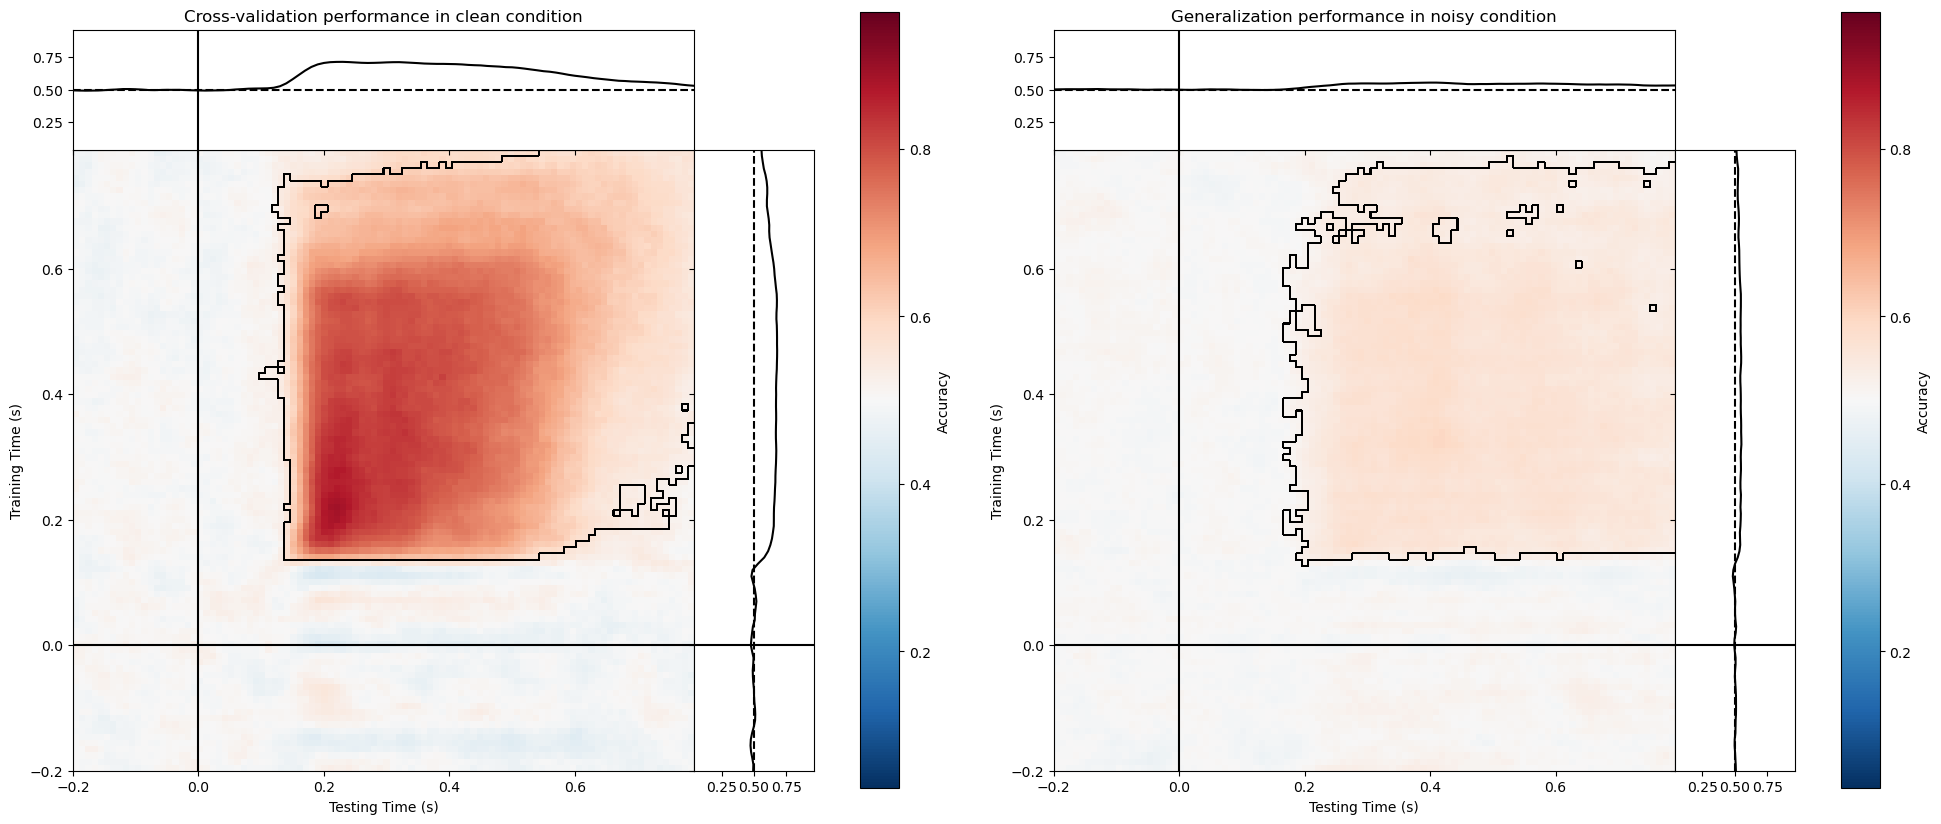

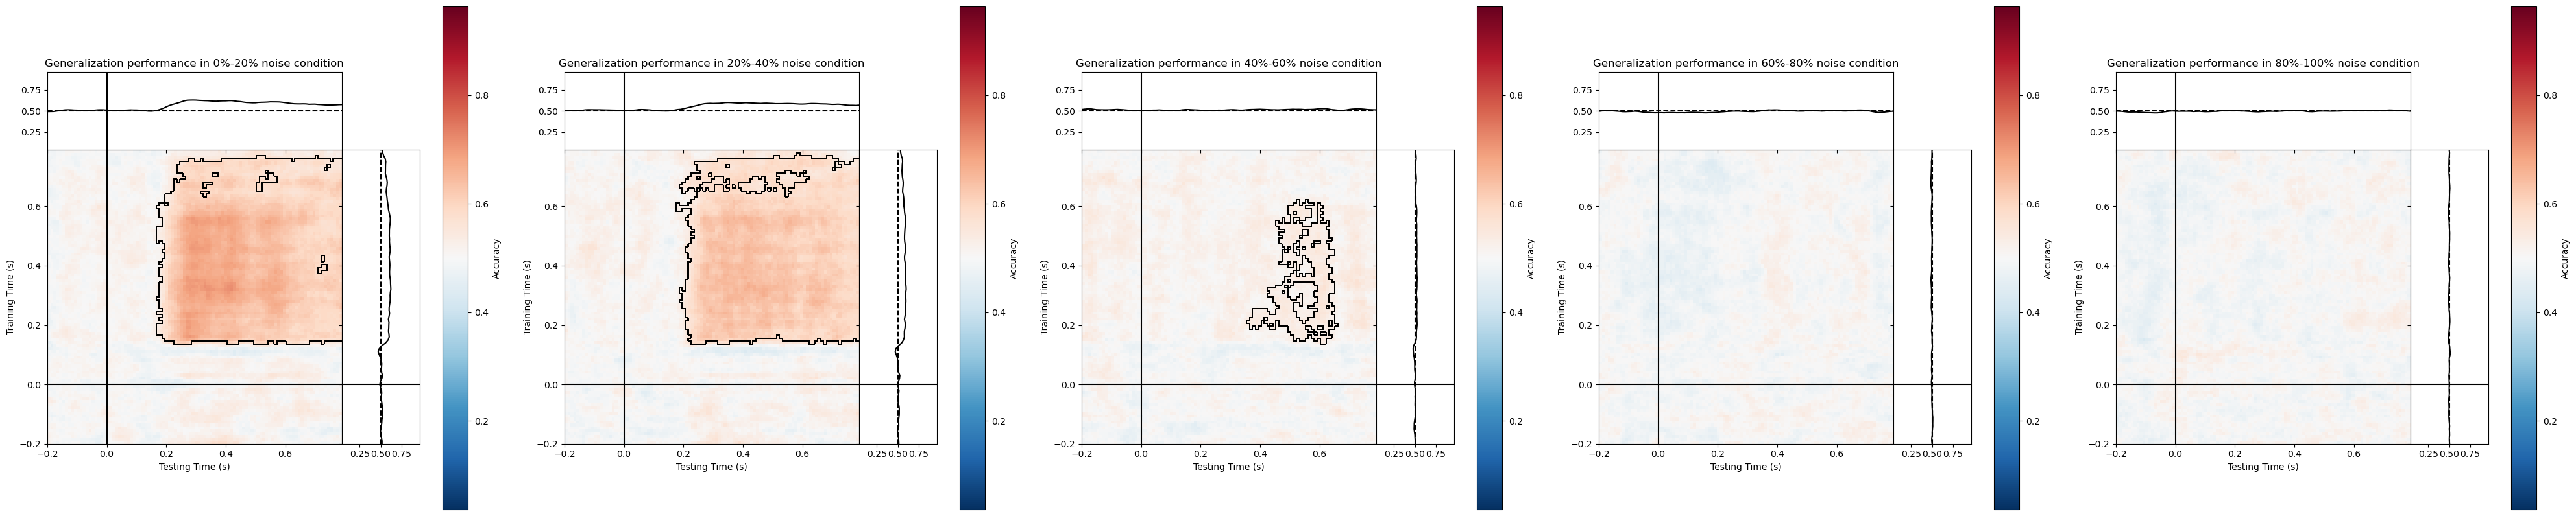

In [98]:
times = np.arange(start_time, end_time, decimate) / 1000
interpolation = "antialiased"
chance = 1/2
mask_mode = "contour"
p = 0.05
n_jobs = -1
tail = 1
metric = "Accuracy"
subject = "all"
plot_noise_levels = True

if subject != "all":
  clean_scores_tmp=clean_scores[subject,...]
  noisy_scores_tmp=noisy_scores[subject,...]
else:
  clean_scores_tmp=clean_scores
  noisy_scores_tmp=noisy_scores

scaling = max(np.abs(clean_scores-chance).max(), np.abs(noisy_scores-chance).max())

fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

plot_generalizing_score(ax1, clean_scores_tmp, times, title="Cross-validation performance in clean condition", scaling=scaling,
                        metric=metric, p=p, tail=tail, n_jobs=n_jobs, mask_mode=mask_mode, interpolation=interpolation)
plot_generalizing_score(ax2, noisy_scores_tmp, times, title="Generalization performance in noisy condition", scaling=scaling,
                        metric=metric, p=p, tail=tail, n_jobs=n_jobs, mask_mode=mask_mode, interpolation=interpolation)

fig1.tight_layout()

if plot_noise_levels:
  if subject != "all":
    noise_level_scores_tmp={k: v[subject,...] for k, v in noise_level_scores.items()}
  else:
    noise_level_scores_tmp=noise_level_scores
  
  fig2, axes = plt.subplots(1, n_noise_bins, figsize=(40, 10))

  for (noise_level, scores), ax in zip(noise_level_scores_tmp.items(), axes):
    plot_generalizing_score(ax, scores, times, title=f"Generalization performance in {noise_level/100-0.2:02.0%}-{noise_level/100:02.0%} noise condition", scaling=scaling,
                      metric=metric, p=p, tail=tail, n_jobs=n_jobs, mask_mode=mask_mode, interpolation=interpolation)
  
  fig2.tight_layout()

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_3531/2568649022.py:3: RuntimeWarning: The measurement information indicates a low-pass frequency of 500 Hz. The decim=10 parameter will result in a sampling frequency of 100 Hz, which can cause aliasing artifacts.
  evoked = mne.EvokedArray(params[subject_n], subjects[subject_n].copy().decimate(decimate).info, tmin=subjects[subject_n].tmin)


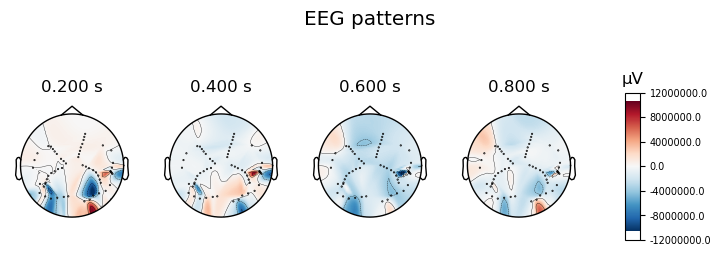

/var/folders/_r/kcfrqwd143bfg9vx3jtb4l6w0000gs/T/ipykernel_3531/2568649022.py:3: RuntimeWarning: The measurement information indicates a low-pass frequency of 500 Hz. The decim=10 parameter will result in a sampling frequency of 100 Hz, which can cause aliasing artifacts.
  evoked = mne.EvokedArray(params[subject_n], subjects[subject_n].copy().decimate(decimate).info, tmin=subjects[subject_n].tmin)


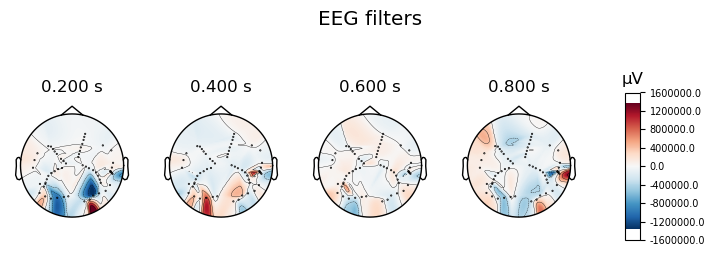

In [36]:
subject_n = 6
for name, params in zip(('patterns', 'filters'), (patterns, filters)):
    evoked = mne.EvokedArray(params[subject_n], subjects[subject_n].copy().decimate(decimate).info, tmin=subjects[subject_n].tmin)
    evoked.plot_topomap(times=[0.2,0.4,0.6,0.8], title='EEG %s' % name, time_unit='s')

In [356]:
print(f"Clean scores:", clean_scores, "Mean:", np.mean(clean_scores))
print(f"Clean scores:", noisy_scores, "Mean:", np.mean(noisy_scores))

Clean scores: [0.55       0.60666667 0.63666667 0.72333333 0.55333333 0.7
 0.56      ] Mean: 0.6185714285714285
Clean scores: [0.50793651 0.53968254 0.50793651 0.53333333 0.48253968 0.50952381
 0.4984127 ] Mean: 0.5113378684807256


In [350]:
time_of_interest = [50,50]
n_noise_bins = 5

subjects = list()
noise_levels = list()
correct_keypresses = list()
correct_preds = list()

for subject in range(7):
    subjects.append(([],[],[]))
    noise_levels.append([])
    correct_keypresses.append([])
    correct_preds.append([])
    for trial in range(len(preds[subject])):
        prediction = preds[subject][trial] # False indicates a house and true a face time_of_interest[0], time_of_interest[1]
        subjects[subject][1].append(prediction != keypresses[subject][2][trial])
        subjects[subject][2].append(keypresses[subject][3][trial])
        subjects[subject][0].append(stimulus_noise[subject][trial])
    for (lower, upper) in zip(np.linspace(0,100, n_noise_bins+1), np.linspace(100/n_noise_bins, 100, n_noise_bins)):
        mask = np.squeeze(np.logical_and(lower < subjects[subject][0], upper >= subjects[subject][0]))
        noise_levels[subject].append(np.mean(np.array(subjects[subject][0])[mask]))
        correct_preds[subject].append(np.mean(np.array(subjects[subject][1])[mask]))
        correct_keypresses[subject].append(np.mean(np.array(subjects[subject][2])[mask]))

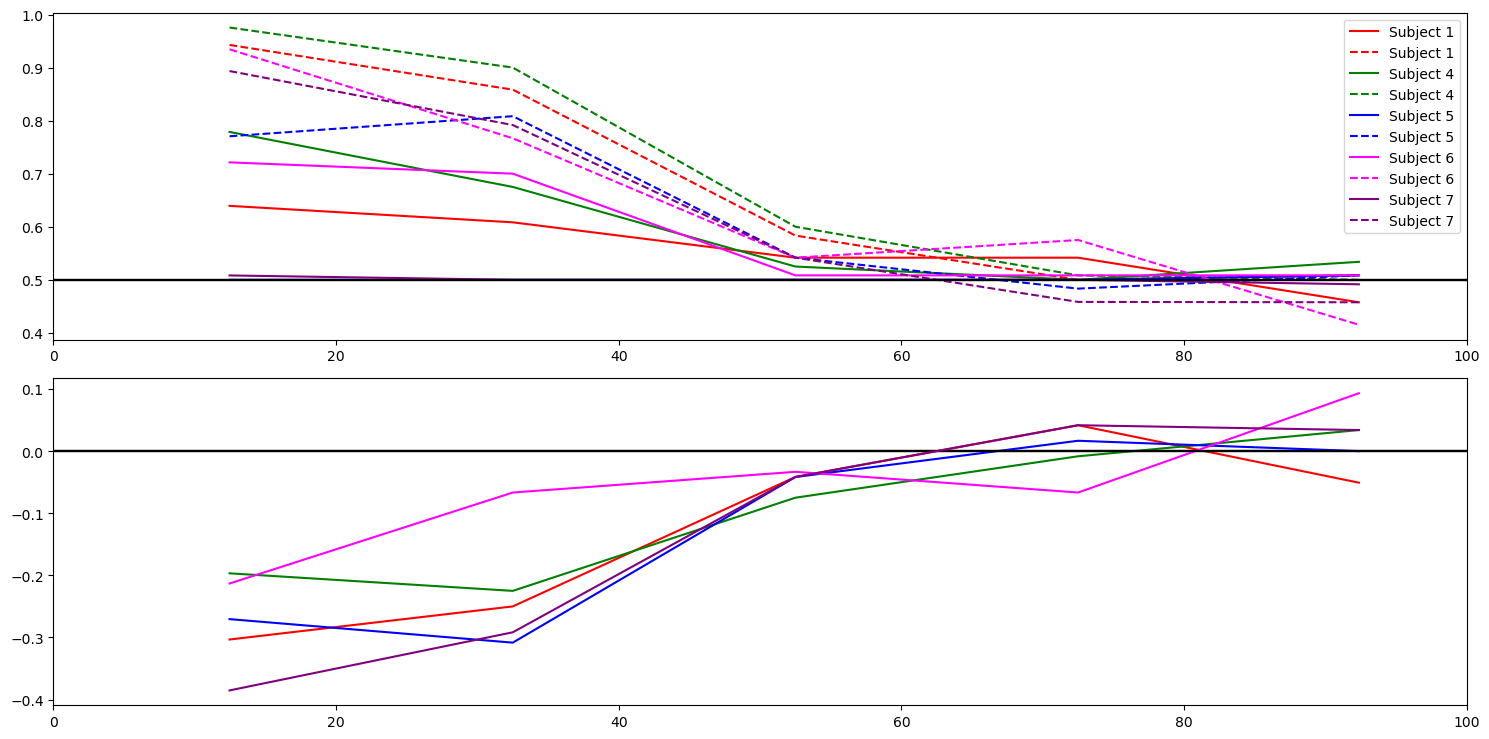

In [351]:
colors = ["red", "cyan", "yellow", "green", "blue", "magenta", "purple"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,7.5))
for subject in range(7):
    if (subject == 1 or subject == 2):
        continue
    ax1.plot(noise_levels[subject], correct_preds[subject], color=colors[subject], label=f"Subject {subject + 1}")
    ax1.plot(noise_levels[subject], correct_keypresses[subject], color=colors[subject], ls="--", label=f"Subject {subject + 1}")
    ax1.axhline(0.5, color="k")
    ax1.legend()
    ax1.set_xlim(0,100)
    ax2.axhline(0, color="k")
    ax2.plot(noise_levels[subject], np.array(correct_preds[subject])-np.array(correct_keypresses[subject]), color=colors[subject], label=f"Subject {subject + 1}")
    ax2.set_xlim(0,100)
    fig.tight_layout()

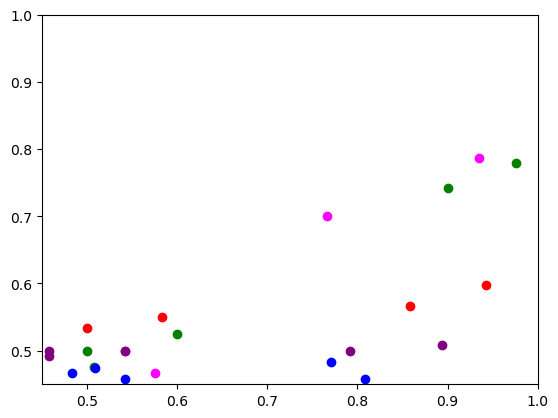

In [347]:
for subject in [0,3,4,5,6]:
    plt.scatter(correct_keypresses[subject], correct_preds[subject], color=colors[subject])
    plt.xlim(0.45,1)
    plt.ylim(0.45,1)

In [294]:
noise_levels[subject]

'subject'

Text(0.5, 1.0, 'Keys vs. predictions')

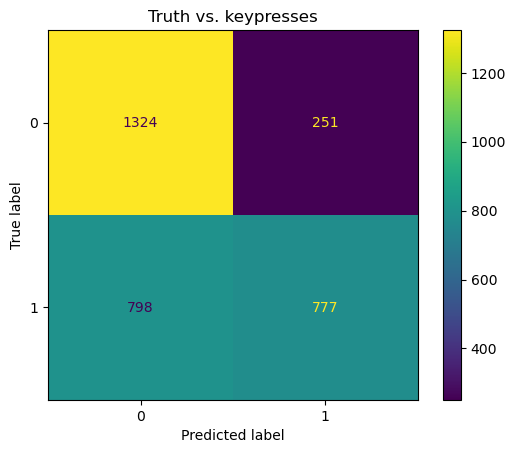

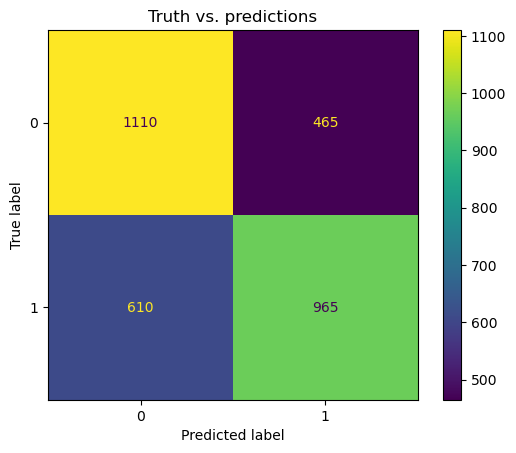

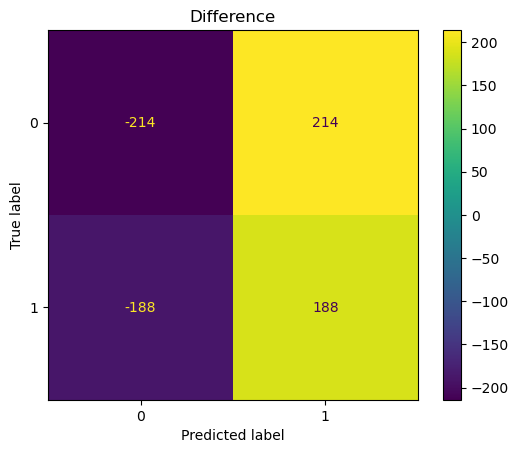

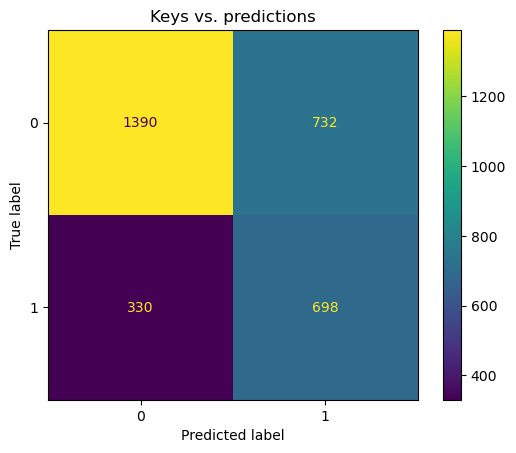

In [297]:
keys = np.concatenate([keypresses[i][0] * 1 for i in [0,3,4,5,6]])
truth = np.concatenate([np.logical_not(keypresses[i][2]) * 1 for i in [0,3,4,5,6]])
predictions = np.concatenate([preds[1] * 1 for i in [0,3,4,5,6]])
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(truth, keys)).plot()
plt.title("Truth vs. keypresses")
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(truth, predictions)).plot()
plt.title("Truth vs. predictions")
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(truth, predictions) - metrics.confusion_matrix(truth, keys)).plot()
plt.title("Difference")
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(keys, predictions)).plot()
plt.title("Keys vs. predictions")

In [241]:
np.where(filters[0] == filters[0].max())

(array([29]), array([43]))

In [307]:
n_channels  = 5

for i in range(7):
    avg_filter = np.mean(np.abs(filters[i]), axis=1)
    print(f"Subject {i+1}")
    for idx in np.argsort(avg_filter)[-n_channels:]:
        print("\tChannel:", idx, "-",  alldat[i][1]["lobe"][idx],  "-", alldat[i][1]["gyrus"][idx], "-", alldat[i][1]["Brodmann_Area"][idx])#, "\t Accuracy:", f"{np.mean(noisy_scores[i]):02.1%}")

Subject 1
	Channel: 33 - Occipital Lobe - Lingual Gyrus - Brodmann area 18
	Channel: 30 - Occipital Lobe - Fusiform Gyrus - Brodmann area 19
	Channel: 27 - Occipital Lobe - Lingual Gyrus - Brodmann area 18
	Channel: 29 - Occipital Lobe - Fusiform Gyrus - Brodmann area 19
	Channel: 34 - Occipital Lobe - Lingual Gyrus - Brodmann area 18
Subject 2
	Channel: 40 - Temporal Lobe - Inferior Temporal Gyrus - Brodmann area 20
	Channel: 27 - Temporal Lobe - Superior Temporal Gyrus - Brodmann area 38
	Channel: 43 - Occipital Lobe - Lingual Gyrus - Brodmann area 18
	Channel: 41 - Temporal Lobe - Inferior Temporal Gyrus - Brodmann area 20
	Channel: 42 - Occipital Lobe - Lingual Gyrus - Brodmann area 18
Subject 3
	Channel: 21 - Parietal Lobe - Postcentral Gyrus - Brodmann area 43
	Channel: 9 - Anterior Lobe - * - Dentate
	Channel: 8 - Anterior Lobe - * - Dentate
	Channel: 5 - Anterior Lobe - * - Dentate
	Channel: 7 - Anterior Lobe - * - Dentate
Subject 4
	Channel: 16 - Temporal Lobe - Middle Tempora

In [310]:
alldat[2][0]["Brodmann_Area"]

True

In [305]:
len(filters)

7